![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [87]:
# Run the cells below first

In [88]:
!pip install torchmetrics
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [89]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

## Downloading the Inbuild Pytorch FashionMNIST Data

In [90]:
import torchvision
from torchvision import datasets, transforms

train_data = datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)


In [91]:
classes=train_data.classes
print(len(classes))

10


## Display the Information about the data

In [92]:
# Display information about the training data
print("Training Data:")
print(f"Number of samples: {len(train_data)}")
print(f"Classes: {train_data.classes}")
print(f"Sample shape: {train_data[0][0].shape}")
print(f"Sample label: {train_data[0][1]}")

# Display information about the test data
print("\nTest Data:")
print(f"Number of samples: {len(test_data)}")
print(f"Classes: {test_data.classes}")
print(f"Sample shape: {test_data[0][0].shape}")
print(f"Sample label: {test_data[0][1]}")

Training Data:
Number of samples: 60000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Sample shape: torch.Size([1, 28, 28])
Sample label: 9

Test Data:
Number of samples: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Sample shape: torch.Size([1, 28, 28])
Sample label: 9


In [93]:
# num_input_channels: The number of input channels for the neural network.
# Since the FashionMNIST dataset consists of grayscale images, there is only 1 input channel.
num_classes=len(train_data.classes)
print(num_classes)
num_input_channels = 1

# num_output_channels: The number of output channels for the first convolutional layer.
# This is typically a hyperparameter that you can adjust based on your model architecture.
num_output_channels = 16

# image_size: The height (or width) of the input images.
# Since FashionMNIST images are 28x28 pixels, we extract the size from the shape of the first image.
image_size = train_data[0][0].shape[1]  # This will be 28 for FashionMNIST

10


## Creating DataLoader 

In [94]:
dataloader_train=DataLoader(
    train_data,
    batch_size=10,
    shuffle=True
)
dataloader_test=DataLoader(
    test_data,
    batch_size=10,
    shuffle=False
)

## Defining The CNN

In [95]:
class ImageClassifierModel(nn.Module):
    def __init__(self,num_classes):
        super(ImageClassifierModel,self).__init__()
        self.conv2d=nn.Conv2d(num_input_channels,num_output_channels,kernel_size=3,stride=1,padding=1)
        self.relu=nn.ReLU()
        self.Maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.flatten=nn.Flatten()
        self.fc=nn.Linear(num_output_channels * (image_size//2)**2, num_classes)
    
    def forward(self,x):
        x=self.conv2d(x)
        x=self.relu(x)
        x=self.Maxpool(x)
        x=self.flatten(x)
        x=self.fc(x)
        return x

## Training Function 

In [96]:
def train_model(optimizer,net,num_epochs):
    criterian= nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        running_loss=0
        for features,labels in dataloader_train:
            optimizer.zero_grad()
            output=net(features)
            loss=criterian(output,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        print(f'epoch {epoch}, loss: {running_loss / len(dataloader_train)}')

## Train the Model

In [79]:
net=ImageClassifierModel(num_classes)
optimizer=optim.Adam(net.parameters(),lr=0.001)
train_model(
    optimizer=optimizer,
    net=net,
    num_epochs=5
)

epoch 0, loss: 0.40139946872655613
epoch 1, loss: 0.2880434298763673


## Define Metrics

In [86]:
accuracy_metric= Accuracy(task='multiclass',num_classes=num_classes)
precision_metric= Precision(task='multiclass',num_classes=num_classes,average=None)
recall_metric= Recall(task='multiclass',num_classes=num_classes,average= None)

## Evaluating the Model 


In [81]:
net.eval()
predictions=[]
for i,(features,labels) in enumerate(dataloader_test):
        output = net(features.reshape(-1, 1, image_size, image_size))
        cat = torch.argmax(output, dim=-1)
        predictions.extend(cat.tolist())
        accuracy_metric(cat, labels)
        precision_metric(cat, labels)
        recall_metric(cat, labels)

## Compute and Print Metrics

In [82]:
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()
print('Accuracy:', accuracy)
print('Precision (per class):', precision)
print('Recall (per class):', recall)


Accuracy: 0.9043999910354614
Precision (per class): [0.8483647108078003, 0.9868553876876831, 0.8578680157661438, 0.909547746181488, 0.8560079336166382, 0.988624632358551, 0.7228797078132629, 0.9426069855690002, 0.9788306355476379, 0.9575936794281006]
Recall (per class): [0.8560000061988831, 0.9760000109672546, 0.8450000286102295, 0.9049999713897705, 0.8619999885559082, 0.9559999704360962, 0.7329999804496765, 0.968999981880188, 0.9710000157356262, 0.9710000157356262]


## Random Image Selection,Evaluating & Showcasing the Results


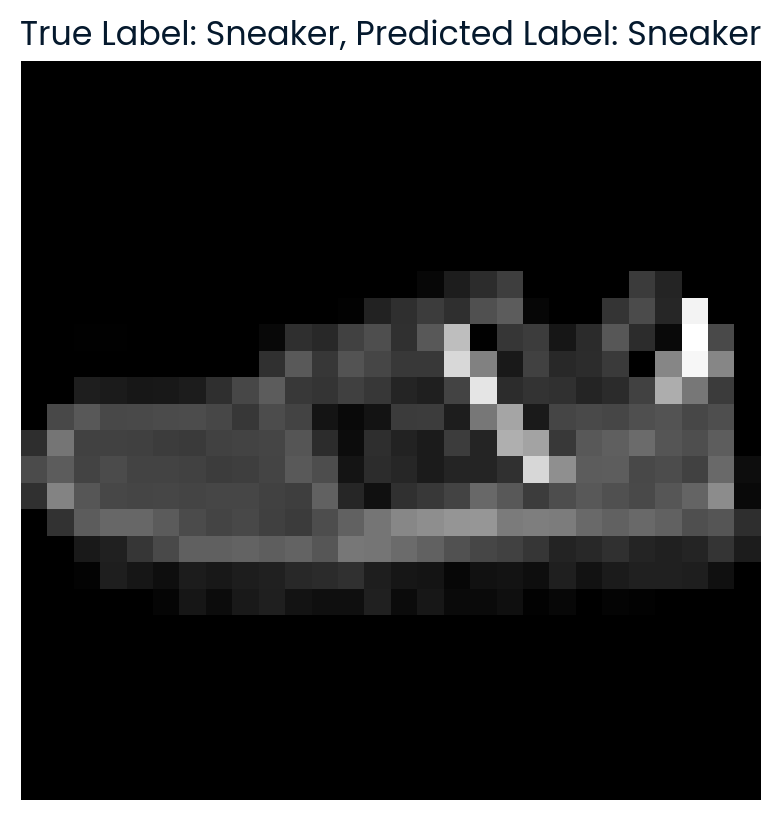

In [83]:
import random
import matplotlib.pyplot as plt

# Randomly select an image from the test dataset
random_idx = random.randint(0, len(test_data) - 1)
random_image, true_label = test_data[random_idx]

# Reshape the image for the model input
random_image_tensor = random_image.unsqueeze(0)  # Add batch dimension

# Now pass it through the model
net.eval()
with torch.no_grad():
    output = net(random_image_tensor)
    predicted_label = torch.argmax(output, dim=-1).item()

# Display the image along with labels
plt.imshow(random_image.squeeze(), cmap="gray")
plt.title(f"True Label: {classes[true_label]}, Predicted Label: {classes[predicted_label]}")
plt.axis("off")
plt.show()